# scikit-leanのSVMについて

「Ipythonデータサイエンスクックブック」に載っている例でsvmの振る舞いを調べてみる。

第８章「機械学習」レシピ8.5


In [9]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets as ds
from sklearn.model_selection import cross_val_score, GridSearchCV
import sklearn.svm as svm
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline


## 訓練データ (1)
2. We generate 2D points and assign a binary label according to a linear operation on the coordinates.

$x + y >1$のときtrue, それ以外はfalseになる$200\times 200$の2次元データyを作る。

In [10]:
X = np.random.randn(200, 2)
y = X[:, 0] + X[:, 1] > 1
# x0 + x1 > 0 のときtrue, それ以外 false => それデータとしてtrue or falseの境界をsvcで見つける

## サポートベクトル識別 (1) 線形

3. We now fit a linear **Support Vector Classifier** (SVC). This classifier tries to separate the two groups of points with a linear boundary (a line here, more generally a hyperplane).

線形識別機の用意　(LinearSVC関数の利用)

In [11]:
# We train the classifier.
est = svm.LinearSVC()
est.fit(X, y);

識別実行のための関数定義

4. We define a function that displays the boundaries and decision function of a trained classifier.

In [12]:
# We generate a grid in the square [-3,3 ]^2.
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))
# This function takes a SVM estimator as input.
def plot_decision_function(est):
    # We evaluate the decision function on the grid.
    Z = est.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cmap = plt.cm.Blues
    # We display the decision function on the grid.
    plt.figure(figsize=(5,5));
    plt.imshow(Z,
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                aspect='auto', origin='lower', cmap=cmap);
    # We display the boundaries.
    plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                colors='k');
    # We display the points with their true labels.
    plt.scatter(X[:, 0], X[:, 1], s=30, c=.5+.5*y, lw=1, 
                cmap=cmap, vmin=0, vmax=1);
    plt.axhline(0, color='k', ls='--');
    plt.axvline(0, color='k', ls='--');
    plt.xticks(());
    plt.yticks(());
    plt.axis([-3, 3, -3, 3]);

5. Let's take a look at the classification results with the linear SVC.

識別の実行と図示

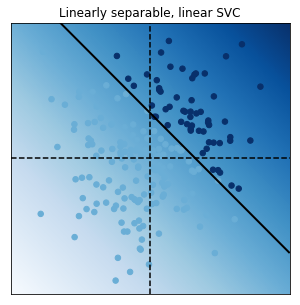

In [13]:
plot_decision_function(est);
plt.title("Linearly separable, linear SVC");

The linear SVC tried to separate the points with a line and it did a pretty good job.

## 訓練データ(2) 線形な境界を引けない場合

6. We now modify the labels with a *XOR* function. A point's label is 1 if the coordinates have different signs. This classification is not linearly separable. Therefore, a linear SVC fails completely.

１，３象限はtrue, ２、４象限はfalseとなるデータを作成し、線形識別してみる。

Score: 0.5


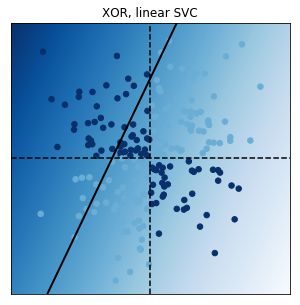

In [14]:
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0) # １，３象限はtrue, ２、４象限はfalse
# We train the classifier.
est = GridSearchCV(svm.LinearSVC(), 
                      {'C': np.logspace(-3., 3., 10)});
est.fit(X, y);
print("Score: {0:.1f}".format(
      cross_val_score(est, X, y).mean()))
# Plot the decision function.
plot_decision_function(est);
plt.title("XOR, linear SVC");

## 非線形変換を含む識別機

データ${\bf x}$ に対する非線形関数$\{{\bf\phi}_1, {\bf\phi}_2, \cdots, {\bf\phi}_M\}$を用意し、
$$
y({\bf x}) = {\bf w}^T {\bf \phi}({\bf x}) +b
$$
のような、目標変数と説明変数の間に非線形な関係があるとし、係数${\bf w} = (w_1, w_2, \cdots, w_M)^T$を学習により求める。

この問題は、$k({\bf x},{\bf x'})= {\bf \phi} ({\bf x})^T{\bf \phi} ({\bf x}')$で定義されるカーネルを用いて

$$
 y({\bf x}) = \sum_{n=1}^{N} a_n t_n k({\bf x}, {\bf x_n}) + b
$$

の形式に変換できることが知られている。ここで$t_n$は訓練データ${\bf x_n}$に対する目標値であり、$a_n$は学習により求める係数である。

<span class="mark">重要な（利）点は、非線形関数${\bf \phi}$を設定するのではなく、カーネル$k({\bf x},{\bf x'})$を指定することにより識別学習を行えることである。（逆に言えば関数${\bf \phi}$はどのようなものかわからない。）</span>

Scikit-learnのSVCでは、カーネルとしては標準的に<span class="mark">ガウシアン放射基底関数(Gaussian Radial Basis Function)</span>が用いられている。

$$
k({\bf x},{\bf x'}) = \exp ( -\gamma || {\bf x}-{\bf x'} ||^2)
$$

が用いられる。パラメータ$\gamma$の値はグリッドサーチや交差検定を使って定められる。

7. Fortunately, it is possible to use non-linear SVCs by using non-linear **kernels**. Kernels specify a non-linear transformation of the points into a higher-dimensional space. Transformed points in this space are assumed to be more linearly separable, although they are not necessarily in the original space. By default, the `SVC` classifier in scikit-learn uses the **Radial Basis Function** (RBF) kernel.

Score: 0.970


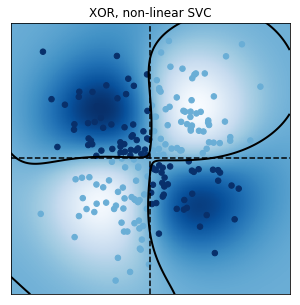

In [15]:
y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
est = GridSearchCV(svm.SVC(), 
                      {'C': np.logspace(-3., 3., 10),
                    'gamma': np.logspace(-3., 3., 10)});
est.fit(X, y);
print("Score: {0:.3f}".format(
      cross_val_score(est, X, y).mean()))
plot_decision_function(est.best_estimator_);
plt.title("XOR, non-linear SVC");

This time, the non-linear SVC does a pretty good job at classifying these non-linearly separable points.

## 関数近似に対するリッジ回帰との比較


SVRは、関数近似の範囲を越えた様々な（数量化）説明変数を加えた回帰を解くことができるが、ここでは単純な１変数関数近似をリッジ回帰と比べてみる。

つぎのような、sin関数にノイズを載せたデータを学習させる。

データとsvrサンプルは

https://qiita.com/hrs1985/items/ba24fde9981f611cc7d8

よりとった。

データの範囲を越えた予測は困難だが、無難な値に収まっている。（べき関数へのリッジ回帰と比べてみてほしい。）

データ数が多ければリッジでもかなり良い結果になるが、少ない場合はSVMの方が良いようだ。


In [6]:
# データ作成用関数

def make_data_by_sin_gaussian():
    PI = 3.14
    # 0～2πまでを何等分かした点を作る
    number_of_data = 20
    X = np.array(range(number_of_data))
    X = X * 2 * PI / number_of_data
    # y=sinXを計算し、ガウス分布に従う誤差を加える
    y = np.sin(X)
    e = [random.gauss(0, 0.2) for i in range(len(y))]
    y += e
    # 列ベクトルに変換する
    X = X[:, np.newaxis]
    return (X, y)

### SVRによる推定

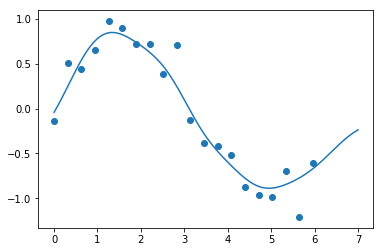

In [12]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import svm

x_max = 7.  # 予測の範囲の上限


if __name__ == '__main__':
    (x,y) = make_data_by_sin_gaussian()
    # 学習を行う
    svr = svm.SVR(kernel='rbf')
    svr.fit(x, y)
    
    # 回帰曲線を描く
    x_plot = np.linspace(0, x_max, 10000)
    y_plot = svr.predict(x_plot[:, np.newaxis])
    
    #グラフにプロットする。
    plt.scatter(x, y)
    plt.plot(x_plot, y_plot)
    plt.show()


### リッジ回帰による推定

基底関数を$n$次のべき関数にしてフィッティングした例


0.05  -0.46  0.72  0.00
-0.00  0.06  -0.29  0.25  0.43  0.00
0.00  -0.00  0.02  -0.02  -0.08  0.04  0.19  0.27  0.00


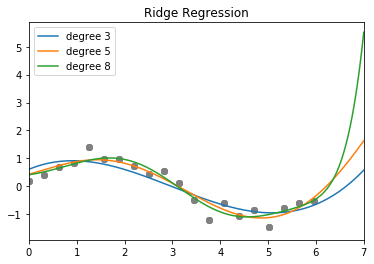

In [11]:
import sklearn.linear_model as lm
ridge = lm.Ridge()
x_max = 7
(x,y) = make_data_by_sin_gaussian()
x_tr = np.linspace(0., x_max, 200)
for deg in [3,5,8]:
    ridge.fit(np.vander(x[:,0], deg +1), y)
    y_ridge = ridge.predict(np.vander(x_tr, deg+1))
    plt.plot(x_tr, y_ridge,
            label='degree ' + str(deg))
    plt.legend(loc=2)
     # モデルの係数表示
    print('  '. join(['%.2f' % c for c in ridge.coef_]))
    plt.scatter(x, y, c='gray')
    plt.xlim(0, x_max)
    plt.title('Ridge Regression')